In [1]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
from termcolor import colored
import ast
import csv
import json 

In [2]:
J = glob.glob('Data_for_Mann_et_al_RSBL/Horspath/**/*.txt')

def read_file(file_name): 
    Data = [0] * len(file_name)

    for i in range(len(file_name)):
        c = 0
        with open(file_name[i], "r") as f:
            Data[i] = []
            for line in f:
                if c > 0:
                    item = line.strip().split("\t")
                    Data[i].append([float(item[0]), float(item[1])])
                else: 
                    c += 1
        Data[i] = np.array(Data[i])
    return np.array(Data)

Data = read_file(J)
Data.shape

(321,)

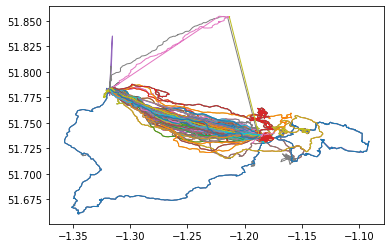

In [3]:
for i in range(len(Data)):
    plt.plot(Data[i][:,0], Data[i][:,1], linewidth = 1)
plt.show()

In [4]:
Min1 = np.min([np.min(Data[i], 0) for i in range(len(Data))], 0)
Max1 = np.max([np.max(Data[i], 0) for i in range(len(Data))], 0)
Mean1 = np.mean([np.mean(Data[i], 0) for i in range(len(Data))], 0)
Std1 = np.std([np.std(Data[i], 0) for i in range(len(Data))], 0)
Min1, Mean1, Max1, Std1

(array([-1.357207, 51.660634]),
 array([-1.26048495, 51.75877014]),
 array([-1.091612, 51.85453 ]),
 array([0.00775313, 0.00402572]))

In [5]:
def reverse1(gamma):
    g = []
    for i in range(len(gamma)):
        g.append(gamma[len(gamma) - i - 1])
    return np.array(g)

def reverse(data):
    g = [0] * len(data)
    for i in range(len(data)):
        g[i] = reverse1(data[i])
    return np.array(g)

In [6]:
random.shuffle(Data)
data_1 = Data[:len(Data)//2]
data_2 = reverse(Data[len(Data)//2:])

In [7]:
def dist_signed_point_closed(Q, gamma, sigma): 
    
    p1 = gamma[:-1]
    p2 = gamma[1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L > 10e-6)[0]
    p1 = p1[II]
    p2 = p2[II]
    gamma = np.array(list(p1) + [p2[-1]])
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1)) + 10e-6
    
    w = (p1-p2)*(-1,1)/(L * np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
# signed distance to the extended lines of segments
    dist_signed = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    x = abs(dist_signed.copy())
    R = (L**2).reshape(-1,1)
# u = argmin points on the extended lines of segments
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)

    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
# d1 = distance to start points
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
# d2 = distance to end points
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))
    d = np.where(d1 < d2, d1, d2)
    dist_segment = np.where(abs(G + H - L) < np.ones(len(L)) * (10e-6), dist_signed, d)
    
    J2 = [0] * len(Q)
    for i in range(len(Q)): 
        J2[i] = np.where(abs(G + H - L)[i] > 10e-6)[0]
    J2 = np.array(J2)

    dist_segment_copy = dist_segment.copy()
    dist = abs(dist_segment_copy)


    j = np.argmin(dist, axis =1)

    sign = np.ones(len(Q))
    for k in range(len(Q)): 
        if j[k] in J2[k]:
            if j[k] == 0 and LA.norm(Q[k] - gamma[0]) < LA.norm(Q[k] - gamma[1]):
                
                y = LA.norm(gamma[0]-gamma[1]) - LA.norm(gamma[-1] - gamma[-2])
                if y < 0:
                    x = gamma[0] + 0.1 * LA.norm(gamma[0]-gamma[1])*(gamma[-2]-gamma[-1])/LA.norm(gamma[-2]-gamma[-1])
                    z = gamma[0] + 0.1 * LA.norm(gamma[0]-gamma[1])*(gamma[1]-gamma[0])/LA.norm(gamma[1]-gamma[0])
                    q = 2 * gamma[0] - (x + z)/2
                else: 
                    x = gamma[0] + 0.1 * LA.norm(gamma[-1]-gamma[-2])*(gamma[1]-gamma[0])
                    z = gamma[0] + 0.1 * LA.norm(gamma[-1]-gamma[-2])*(gamma[-2]-gamma[-1])
                    q = 2 * gamma[0] - (x + z)/2
                sign[k] = np.sign((q-gamma[-1]).dot(w[-1] + w[0]))
                
            elif j[k] == len(gamma)-2 and LA.norm(Q[k] - gamma[-1]) < LA.norm(Q[k] - gamma[-2]):
                s = w[-1].dot((Q[k] - gamma[-1])/ LA.norm(Q[k] - gamma[-1]) + 10e-6)
                sign[k] = np.sign(s)
            
            elif LA.norm(Q[k] - gamma[j[k]]) < LA.norm(Q[k] - gamma[j[k]+1]):  
                q = 2 * gamma[j[k]] - (gamma[j[k]-1] + gamma[j[k]+1])/2
                sign[k] = np.sign((q-gamma[j[k]]).dot(w[j[k]-1] + w[j[k]]))
                    
            elif LA.norm(Q[k] - gamma[j[k]+1]) <= LA.norm(Q[k] - gamma[j[k]]):
                q = 2 * gamma[j[k]+1] - (gamma[j[k]] + gamma[j[k]+2])/2
                sign[k] = np.sign((q-gamma[j[k]+1]).dot(w[j[k]] + w[j[k]+1]))

    E = dist_segment[np.arange(len(dist_segment)),j] 
    F = dist[np.arange(len(dist)),j] 
    dist_weighted = sign * (1/sigma) * (E.reshape(-1,1) * np.exp(-(F/sigma)**2).reshape(-1,1)).reshape(1,-1)
  
    return dist_weighted.reshape(len(Q))

In [8]:
def dist_signed_point_unclosed(Q, gamma, sigma): # New
    
    h = 10e-8
    p1 = gamma[:-1]
    p2 = gamma[1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L > h)[0]
    p1 = p1[II]
    p2 = p2[II]
    gamma = np.array(list(p1) + [p2[-1]]) 
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1)) 
    w = (p1-p2)*(-1,1)/(L * np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
# signed distance to the extended lines of segments
    dist_signed = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    b = dist_signed + 0
    x = abs(b)
    R = (L**2).reshape(-1,1)

# u = argmin points on the extended lines of segments
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)

    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
# d1 = distance to start points
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
# d2 = distance to end points
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))
    d = np.where(d1 < d2, d1, d2)

    dist_segment = np.where(abs(G + H - L) < np.ones(len(L)) * 2*h, dist_signed, d)

    J2 = [0] * len(Q)
    for i in range(len(Q)): 
        J2[i] = np.where(abs(G + H - L)[i] > 2 * h)[0]
    J2 = np.array(J2, dtype = 'object')
    
    dist_segment_copy = dist_segment + 0
    dist = abs(dist_segment_copy)
    
    dist_from_start_1 = np.sqrt(((Q -p1[0])*(Q -p1[0])).sum(axis =1))
    ds_1 = ((Q -p1[0])*w[0]).sum(axis =1)
    dist_from_start = ds_1 * np.maximum(abs(ds_1), np.sqrt(dist_from_start_1**2 - ds_1**2 + 
                                                        h))/ (dist_from_start_1 + h)

    dist_from_end_1 = np.sqrt(((Q -p2[-1])*(Q -p2[-1])).sum(axis =1))
    de_1 = ((Q -p2[-1])* w[-1]).sum(axis =1)
    dist_from_end = de_1 * np.maximum(abs(de_1), np.sqrt(dist_from_end_1**2 - 
                                                de_1**2 + h))/ (dist_from_end_1+ h)
    
    dist_segment[:,0] = np.where(abs(dist[:,0]- dist_from_start_1)< h**2, 
                                 dist_from_start, dist_segment[:,0]) 
    
    dist_segment[:,-1] = np.where(abs(dist[:,-1]- dist_from_end_1)< h**2, 
                                  dist_from_end, dist_segment[:,-1]) 

    j = np.argmin(dist, axis =1)
    sign = np.ones(len(Q))
    for k in range(len(Q)): 
        if j[k] in J2[k]: 
            if j[k] == 0 and LA.norm(Q[k] - gamma[0]) < LA.norm(Q[k] - gamma[1]):
                sign[k] = 1
                
            elif j[k] == len(gamma)-2 and LA.norm(Q[k] - gamma[j[k]+1]) < LA.norm(Q[k] - 
                                                                            gamma[j[k]]):
                sign[k] = 1
            elif LA.norm(Q[k] - gamma[j[k]]) < LA.norm(Q[k] - gamma[j[k]+1]):  
                q = 2 * gamma[j[k]] - (gamma[j[k]-1] + gamma[j[k]+1])/2
                sign[k] = np.sign((q-gamma[j[k]]).dot(w[j[k]-1] + w[j[k]]))
            elif LA.norm(Q[k] - gamma[j[k]+1]) <= LA.norm(Q[k] - gamma[j[k]]):
                q = 2 * gamma[j[k]+1] - (gamma[j[k]] + gamma[j[k]+2])/2
                sign[k] = np.sign((q-gamma[j[k]+1]).dot(w[j[k]] + w[j[k]+1]))
    E = dist_segment[np.arange(len(dist_segment)),j] 
    F = dist[np.arange(len(dist)),j] 
    dist_weighted = (1/sigma) * sign * (E.reshape(-1,1) *
                        np.exp(-(F/sigma)**2).reshape(-1,1)).reshape(1,-1)

    return dist_weighted.reshape(len(Q))

In [9]:
def dist_signed_point(Q, gamma, sigma):
    
    if LA.norm(gamma[0]-gamma[-1]) > 10e-6:
        A = dist_signed_point_unclosed(Q, gamma, sigma)
    else: 
        A = dist_signed_point_closed(Q, gamma, sigma)
        
    return A

In [26]:
m = 20
Q = np.ones((m,2))

Q[:,0] = np.random.normal(Mean1[0], Std1[0] + 0.04, m)
Q[:,1] = np.random.normal(Mean1[1], Std1[1] + 0.03, m)

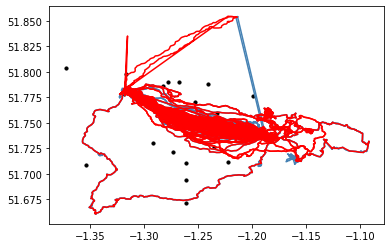

In [27]:
for k in range(len(data_1)):
    plt.plot(data_1[k][:,0], data_1[k][:,1], color = "steelblue");
    
for k in range(len(data_2)):
    plt.plot(data_2[k][:,0], data_2[k][:,1], color = "red");

plt.scatter(Q[:,0], Q[:,1], s=10, color= 'black');
plt.show()

In [28]:
len(data_1), len(data_2)

(160, 161)

In [29]:
sigma = 0.05
projected_1 = [0] * len(data_1) 
projected_2 = [0] * len(data_2)

Start_time = time.time()

for i in range(len(data_1)):
    projected_1[i] = np.concatenate((dist_signed_point_unclosed(Q,data_1[i],sigma),[1]), axis = 0)

for i in range(len(data_2)):
    projected_2[i] = np.concatenate((dist_signed_point_unclosed(Q,data_2[i],sigma),[-1]), axis = 0)
    
projected_1 = np.array(projected_1)
projected_2 = np.array(projected_2)

print('total time =', time.time() - Start_time)

total time = 2.645822763442993


In [31]:
clf1 = svm.SVC(C=10000, kernel='linear') 
clf2 = make_pipeline(StandardScaler(), svm.SVC(C= 100, kernel = 'rbf', gamma= 'auto', max_iter = 200000))
clf3 = make_pipeline(StandardScaler(), svm.SVC(C = 1000, kernel = 'poly', max_iter = 400000))
clf4 = DecisionTreeClassifier()
clf5 = RandomForestClassifier(n_estimators=100) 

clf = [clf1,clf2,clf3,clf4, clf5]

In [38]:
Start_time = time.time()

n_1 = len(data_1)
n_2 = len(data_2)
t = 1000

error_train = np.zeros((len(clf), t))
error_test = np.zeros((len(clf), t))

for i in range(t): 

    R1 = random.sample(range(n_1), n_1//3)
    R = np.sort(R1)
    R_c = np.sort(list(set(range(n_1)) - set(R)))
    
    S1 = random.sample(range(n_2), n_2//3)
    S = np.sort(S1)
    S_c = np.sort(list(set(range(n_2)) - set(S)))
    
    data_train = np.insert(projected_1[R_c], len(R_c), projected_2[S_c], axis = 0)
    data_test = np.insert(projected_1[R], len(R), projected_2[S], axis = 0)
    
    data_train = list(data_train)
    data_test = list(data_test)
    random.shuffle(data_train)
    random.shuffle(data_test)
    data_train = np.array(data_train)
    data_test = np.array(data_test)
    
    for k in range(len(clf)):
        
        model = clf[k]
        #Train the model using the training sets
        model.fit(data_train[:,:-1], data_train[:,-1])

        #Predict the response for test dataset
        y_pred = model.predict(data_test[:,:-1])
        error_test[k][i] = 1 - metrics.accuracy_score(data_test[:,-1], y_pred)
                
        x_pred = model.predict(data_train[:,:-1])
        error_train[k][i] = 1 - metrics.accuracy_score(data_train[:,-1], x_pred)

print('total time =', time.time() - Start_time)

total time = 100.87731790542603


In [39]:
# Data = Horsepath
print('total time =', time.time() - Start_time)
print('Q =', Q) 
print('sigma =', sigma)
print('Number of runs:', t)

Dic = {}

models = ["Linear kernel SVM, C=10000", "Gaussian kernel SVM, C=100, gamma = auto",
          "Poly kernel SVM, deg=auto, C=1000", "Decision Tree","RandomForestClassifier, n=100"]

for k in range(len(models)): 
    Dic[k+1] = [models[k], np.round(np.mean(error_train[k]), decimals = 4), 
                np.round(np.mean(error_test[k]), decimals = 4),
               np.round(np.std(error_test[k]), decimals = 4)]
    
pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 'Test Error', 
                                                     'Std Error'])

total time = 100.88540196418762
Q = [[-1.25308083 51.77046653]
 [-1.28214079 51.7865374 ]
 [-1.22243767 51.71159935]
 [-1.25906133 51.7473446 ]
 [-1.35372865 51.70904241]
 [-1.26799228 51.78960201]
 [-1.37247517 51.80404299]
 [-1.26108992 51.71049017]
 [-1.23546372 51.72625205]
 [-1.26051033 51.75088581]
 [-1.1986576  51.77591792]
 [-1.26107556 51.69373777]
 [-1.31883574 51.77801643]
 [-1.23248486 51.75956104]
 [-1.27819678 51.78988488]
 [-1.26099181 51.67153644]
 [-1.29156797 51.73019009]
 [-1.2405062  51.78823727]
 [-1.31692687 51.7975605 ]
 [-1.2736309  51.720971  ]]
sigma = 0.05
Number of runs: 1000


,Classifier,Train Error,Test Error,Std Error
1,"Linear kernel SVM, C=10000",0.0,0.0109,0.0093
2,"Gaussian kernel SVM, C=100, gamma = auto",0.0,0.0110,0.0077
3,"Poly kernel SVM, deg=auto, C=1000",0.0,0.0086,0.0084
4,Decision Tree,0.0,0.0016,0.0071
5,"RandomForestClassifier, n=100",0.0,0.0088,0.0085


# Old distance (without direction)

In [40]:
def old_dist(Q, gamma):
    
    p2 = gamma[1:]
    p1 = gamma[:-1]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L>10e-8)[0]
    L = L[II]
    p1 = p1[II]
    p2 = p2[II]
    w = (p1-p2)*(-1,1)/(L*np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
    dist_dot = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    
    x = abs(dist_dot.copy())
    R = (L**2).reshape(-1,1)
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)
    
    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))

    dist = np.where(abs(G + H - L) < np.ones(len(L)) * (10e-8), x, np.minimum(d1, d2))

    j = np.argmin(dist, axis =1)
    dist_weighted = dist[np.arange(len(dist)),j] 
    
    return dist_weighted.reshape(len(Q)) 

In [41]:
proj_1 = [0] * n_1
proj_2 = [0] * n_2

Start_time = time.time()

for i in range(n_1):
    proj_1[i] = np.concatenate((old_dist(Q,data_1[i]),[1]), axis = 0)

for i in range(n_2):
    proj_2[i] = np.concatenate((old_dist(Q,data_2[i]),[-1]), axis = 0)
    
proj_1 = np.array(proj_1)
proj_2 = np.array(proj_2)

print('total time =', time.time() - Start_time)

total time = 1.733016014099121


In [42]:
Start_time = time.time()

t = 1000
error_train = np.zeros((len(clf), t))
error_test = np.zeros((len(clf), t))

for i in range(t): 

    R1 = random.sample(range(n_1), n_1//3)
    R = np.sort(R1)
    R_c = np.sort(list(set(range(n_1)) - set(R)))
    
    S1 = random.sample(range(n_2), n_2//3)
    S = np.sort(S1)
    S_c = np.sort(list(set(range(n_2)) - set(S)))
    
    data_train = np.insert(proj_1[R_c], len(R_c), proj_2[S_c], axis = 0)
    data_test = np.insert(proj_1[R], len(R), proj_2[S], axis = 0)
    
    data_train = list(data_train)
    data_test = list(data_test)
    random.shuffle(data_train)
    random.shuffle(data_test)
    data_train = np.array(data_train)
    data_test = np.array(data_test)
    
    for k in range(len(clf)):
        
        model = clf[k]
        #Train the model using the training sets
        model.fit(data_train[:,:-1], data_train[:,-1])

        #Predict the response for test dataset
        y_pred = model.predict(data_test[:,:-1])
        error_test[k][i] = 1 - metrics.accuracy_score(data_test[:,-1], y_pred)
        
        x_pred = model.predict(data_train[:,:-1])
        error_train[k][i] = 1 - metrics.accuracy_score(data_train[:,-1], x_pred)
        
print(time.time() - Start_time)

139.94831085205078


In [43]:
# Data = Horsepath
print('Q =', Q) 
print('Number of runs:', t) 

Dic = {}

models = ["Linear kernel SVM, C=10000", "Gaussian SVM, C = 100, gamma = auto", 
          "Poly kernel SVM, deg=auto", "Decision Tree", "RandomForestClassifier, n=100"]

for k in range(len(models)): 
    Dic[k+1] = [models[k], np.round(np.mean(error_train[k]), decimals = 4), 
                np.round(np.mean(error_test[k]), decimals = 4),
               np.round(np.std(error_test[k]), decimals = 4)]
    
pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 'Test Error', 
                                                     'Std Error'])

Q = [[-1.25308083 51.77046653]
 [-1.28214079 51.7865374 ]
 [-1.22243767 51.71159935]
 [-1.25906133 51.7473446 ]
 [-1.35372865 51.70904241]
 [-1.26799228 51.78960201]
 [-1.37247517 51.80404299]
 [-1.26108992 51.71049017]
 [-1.23546372 51.72625205]
 [-1.26051033 51.75088581]
 [-1.1986576  51.77591792]
 [-1.26107556 51.69373777]
 [-1.31883574 51.77801643]
 [-1.23248486 51.75956104]
 [-1.27819678 51.78988488]
 [-1.26099181 51.67153644]
 [-1.29156797 51.73019009]
 [-1.2405062  51.78823727]
 [-1.31692687 51.7975605 ]
 [-1.2736309  51.720971  ]]
Number of runs: 1000


,Classifier,Train Error,Test Error,Std Error
1,"Linear kernel SVM, C=10000",0.4255,0.5183,0.0387
2,"Gaussian SVM, C = 100, gamma = auto",0.1873,0.4927,0.0405
3,"Poly kernel SVM, deg=auto",0.1715,0.5087,0.0399
4,Decision Tree,0.0063,0.5075,0.0460
5,"RandomForestClassifier, n=100",0.0063,0.5149,0.0398
